<div style="text-align: center;">
    <h1>SVM</h1>
</div>

# Importar Bibliotecas

In [502]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE 
from collections import Counter
import matplotlib.pyplot as plt

# Carregar e explorar o dataset

In [504]:
df = pd.read_csv('C:/Users/wesle/machine-learning-tecnicas/Dataset/depression_data.csv')

In [505]:
# Visualizar as Primeiras Linhas
print(df.head(5))

   id  school_year  age  gender        bmi          who_bmi  phq_score  \
0   1            1   19    male  33.333333  Class I Obesity          9   
1   2            1   18    male  19.841270           Normal          8   
2   3            1   19    male  25.102391       Overweight          8   
3   4            1   18  female  23.738662           Normal         19   
4   5            1   18    male  25.617284       Overweight          6   

  depression_severity depressiveness suicidal depression_diagnosis  \
0                Mild          False    False                False   
1                Mild          False    False                False   
2                Mild          False    False                False   
3   Moderately severe           True     True                False   
4                Mild          False    False                False   

  depression_treatment  gad_score anxiety_severity anxiousness  \
0                False         11         Moderate        True   
1 

In [506]:
# Resumo Estatístico
print(df.describe())

               id  school_year         age         bmi   phq_score  \
count  783.000000   783.000000  783.000000  783.000000  783.000000   
mean   392.000000     2.277139   20.233716   23.420533    7.123883   
std    226.176922     1.163633    1.767217    4.563630    4.426580   
min      1.000000     1.000000   18.000000    0.000000    0.000000   
25%    196.500000     1.000000   19.000000   20.989420    4.000000   
50%    392.000000     2.000000   20.000000   23.140496    6.000000   
75%    587.500000     3.000000   21.000000   25.519924    9.000000   
max    783.000000     4.000000   31.000000   54.552668   24.000000   

        gad_score  epworth_score  
count  783.000000     775.000000  
mean     6.810983       6.376774  
std      4.727352       3.996443  
min      0.000000       0.000000  
25%      3.000000       3.500000  
50%      6.000000       6.000000  
75%      9.000000       9.000000  
max     21.000000      32.000000  


In [507]:
# Informações do DataFrame
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 783 entries, 0 to 782
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    783 non-null    int64  
 1   school_year           783 non-null    int64  
 2   age                   783 non-null    int64  
 3   gender                783 non-null    object 
 4   bmi                   783 non-null    float64
 5   who_bmi               783 non-null    object 
 6   phq_score             783 non-null    int64  
 7   depression_severity   779 non-null    object 
 8   depressiveness        780 non-null    object 
 9   suicidal              782 non-null    object 
 10  depression_diagnosis  782 non-null    object 
 11  depression_treatment  779 non-null    object 
 12  gad_score             783 non-null    int64  
 13  anxiety_severity      783 non-null    object 
 14  anxiousness           777 non-null    object 
 15  anxiety_diagnosis     7

In [508]:
# Valores Únicos por Coluna
print(df.nunique())

id                      783
school_year               4
age                      13
gender                    2
bmi                     516
who_bmi                   7
phq_score                24
depression_severity       6
depressiveness            2
suicidal                  2
depression_diagnosis      2
depression_treatment      2
gad_score                22
anxiety_severity          5
anxiousness               2
anxiety_diagnosis         2
anxiety_treatment         2
epworth_score            24
sleepiness                2
dtype: int64


In [509]:
# Verificar Dados Ausentes
print(df.isnull().sum())

id                      0
school_year             0
age                     0
gender                  0
bmi                     0
who_bmi                 0
phq_score               0
depression_severity     4
depressiveness          3
suicidal                1
depression_diagnosis    1
depression_treatment    4
gad_score               0
anxiety_severity        0
anxiousness             6
anxiety_diagnosis       4
anxiety_treatment       2
epworth_score           8
sleepiness              8
dtype: int64


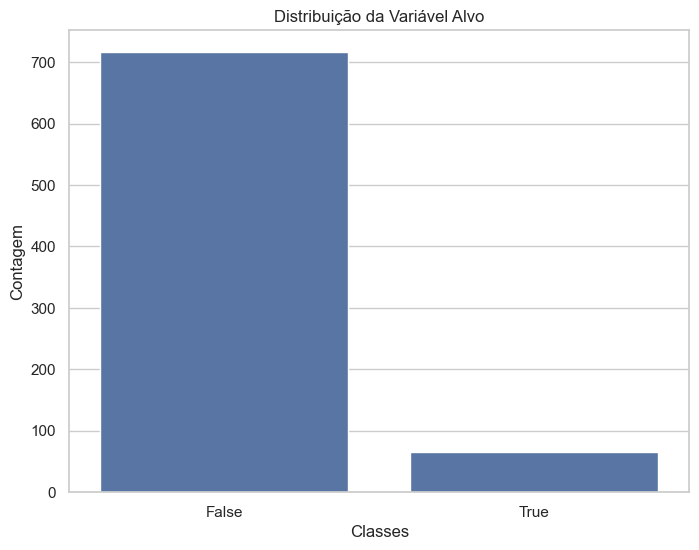

In [510]:
# Distribuição da Variável Alvo
plt.figure(figsize=(8, 6))
sns.countplot(x='depression_diagnosis', data=df)
plt.title('Distribuição da Variável Alvo')
plt.xlabel('Classes')
plt.ylabel('Contagem')
plt.show()

# Remoção de missings e transformação de dados categóricos para numéricos

In [512]:
df.drop('id', axis = 1, inplace = True)

In [513]:
print('Antes da remoção de missings:\n', df['depression_diagnosis'].value_counts())

Antes da remoção de missings:
 depression_diagnosis
False    716
True      66
Name: count, dtype: int64


In [514]:
df.dropna(inplace = True) #removendo valores missing, 18 observações foram removidos (783-165)

In [515]:
print('Depois da remoção de missings:\n', df['depression_diagnosis'].value_counts())

Depois da remoção de missings:
 depression_diagnosis
False    699
True      66
Name: count, dtype: int64


In [516]:
df = df[df['who_bmi'] != 'Not Availble'] #a partir daqui, not availble não aparece mais, pega todos os elementos menos ele, isso significa que mais 8 observações foram removidas

In [517]:
df.shape

(757, 18)

In [518]:
#gender
df['gender'] = df['gender'].map({'female':0,'male':1})

#who_bmi
df['who_bmi'] = df['who_bmi'].map( {
    "Underweight": 0,
    "Normal": 1,
    "Overweight": 2,
    "Class I Obesity": 3,
    "Class II Obesity": 4,
    "Class III Obesity": 5,
})

#depression_severity
df['depression_severity'] = df['depression_severity'].map({
    "none": 0,
    "None-minimal": 1,
    "Mild":2,
    "Moderate": 3,
    "Moderately severe": 4,
    "Severe": 5,
})

#anxiety_severity
df['anxiety_severity'] = df['anxiety_severity'].replace(0, 'none')

df['anxiety_severity'] = df['anxiety_severity'].replace({
    'none': 0,
    "None-minimal": 1,
    "Mild": 2,
    "Moderate": 3,
    "Severe": 4
})


C:\Users\wesle\AppData\Local\Temp\ipykernel_9696\114210172.py:27: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['anxiety_severity'] = df['anxiety_severity'].replace({


In [519]:
colunas = ['depressiveness','suicidal', 'depression_treatment', 'anxiousness', 'anxiety_diagnosis', 'anxiety_treatment', 'sleepiness', 'depression_diagnosis']

for coluna in colunas:
    df[coluna] = df[coluna].astype(int)

In [520]:
df

,school_year,age,gender,bmi,who_bmi,phq_score,depression_severity,depressiveness,suicidal,depression_diagnosis,depression_treatment,gad_score,anxiety_severity,anxiousness,anxiety_diagnosis,anxiety_treatment,epworth_score,sleepiness
0,1,19,1,33.333333,3,9,2,0,0,0,0,11,3,1,0,0,7.0,0
1,1,18,1,19.841270,1,8,2,0,0,0,0,5,2,0,0,0,14.0,1
2,1,19,1,25.102391,2,8,2,0,0,0,0,6,2,0,0,0,6.0,0
3,1,18,0,23.738662,1,19,4,1,1,0,0,15,4,1,0,0,11.0,1
4,1,18,1,25.617284,2,6,2,0,0,0,0,14,3,1,0,0,3.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
778,4,24,0,21.096191,1,6,2,0,0,0,0,1,1,0,0,0,3.0,0
779,4,22,1,25.308642,2,4,1,0,0,0,0,6,2,0,0,0,3.0,0
780,4,22,1,22.720438,1,2,1,0,0,0,0,5,2,0,0,0,4.0,0
781,4,22,0,23.033168,1,17,4,1,0,0,0,19,4,1,0,0,15.0,1


# Separando as características (X) e rótulos (y)

In [522]:
X = df.drop(columns=['depression_diagnosis'])
y = df['depression_diagnosis']

# Divisão do dataset em treino e teste

In [524]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Padronização das características

In [526]:
scaler = StandardScaler()
#Selecionando apenas as características com diferentes escalas
cols_to_scale = ['age', 'bmi', 'phq_score', 'gad_score', 'epworth_score']

X_train[cols_to_scale] = scaler.fit_transform(X_train[cols_to_scale])
X_test[cols_to_scale] = scaler.transform(X_test[cols_to_scale])

# Cenário 1 - All features

## Balanceamento dos dados de treino

In [529]:
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)
print(f"Distribuição das classes após SMOTE: {Counter(y_train_balanced)}")

Distribuição das classes após SMOTE: Counter({0: 484, 1: 484})


## Treinamento e avaliação do modelo com kernel 'rbf'

Acurácia média da validação cruzada: 89.87%
Desvio padrão da acurácia: 2.18%
Relatório do modelo

               precision    recall  f1-score   support

           0       0.96      0.89      0.92       209
           1       0.32      0.58      0.42        19

    accuracy                           0.86       228
   macro avg       0.64      0.73      0.67       228
weighted avg       0.91      0.86      0.88       228



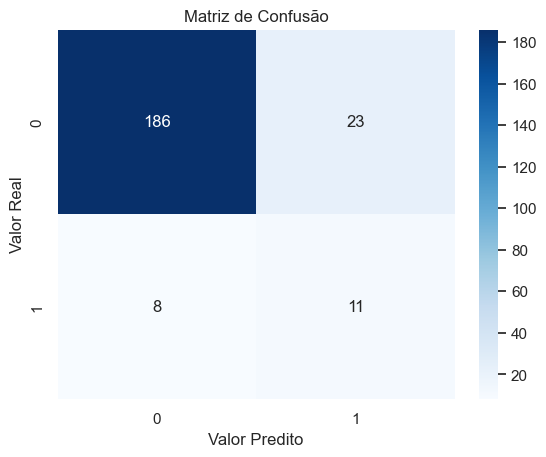

In [531]:
#Instanciando o modelo com kernel 'rbf' (default)
svm = SVC(kernel='rbf', random_state = 42)

cv_scores = cross_val_score(svm, X_train_balanced, y_train_balanced, cv = 10, scoring='accuracy')
print(f"Acurácia média da validação cruzada: {cv_scores.mean() * 100:.2f}%")
print(f"Desvio padrão da acurácia: {cv_scores.std() * 100:.2f}%")

svm.fit(X_train_balanced, y_train_balanced)

y_pred = svm.predict(X_test)

matriz_conf = confusion_matrix(y_test, y_pred)

sns.heatmap(matriz_conf, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['0', '1'], 
            yticklabels=['0', '1'])

plt.title('Matriz de Confusão')
plt.xlabel('Valor Predito')
plt.ylabel('Valor Real');

print('Relatório do modelo\n\n', classification_report(y_test, y_pred))

## Treinamento e avaliação do modelo com kernel 'linear'

Acurácia média da validação cruzada: 84.71%
Desvio padrão da acurácia: 3.26%
Relatório do modelo

               precision    recall  f1-score   support

           0       0.97      0.90      0.94       209
           1       0.40      0.74      0.52        19

    accuracy                           0.89       228
   macro avg       0.69      0.82      0.73       228
weighted avg       0.93      0.89      0.90       228



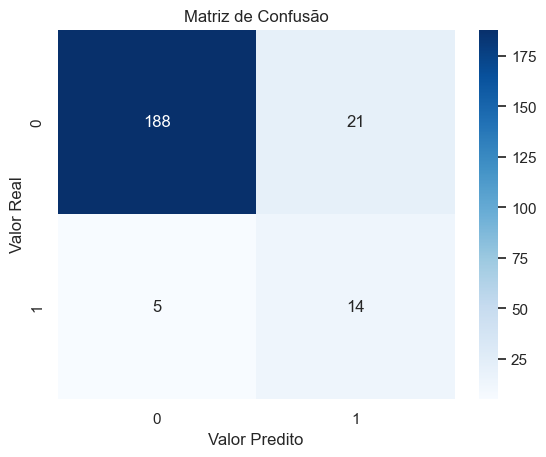

In [533]:
#Instanciando o modelo com kernel 'linear'
svm = SVC(kernel='linear', random_state = 42)

#avaliando o modelo com o cross-validation
cv_scores = cross_val_score(svm,X_train_balanced, y_train_balanced, cv = 10, scoring='accuracy')
print(f"Acurácia média da validação cruzada: {cv_scores.mean() * 100:.2f}%")
print(f"Desvio padrão da acurácia: {cv_scores.std() * 100:.2f}%")

svm.fit(X_train_balanced, y_train_balanced)

y_pred = svm.predict(X_test)

matriz_conf = confusion_matrix(y_test, y_pred)

sns.heatmap(matriz_conf, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['0', '1'], 
            yticklabels=['0', '1'])

plt.title('Matriz de Confusão')
plt.xlabel('Valor Predito')
plt.ylabel('Valor Real');

print('Relatório do modelo\n\n', classification_report(y_test, y_pred))

## Treinamento e avaliação do modelo com kernel 'poly'

Acurácia média da validação cruzada: 89.15%
Desvio padrão da acurácia: 3.05%
Relatório do modelo

               precision    recall  f1-score   support

           0       0.96      0.87      0.91       209
           1       0.30      0.63      0.41        19

    accuracy                           0.85       228
   macro avg       0.63      0.75      0.66       228
weighted avg       0.91      0.85      0.87       228



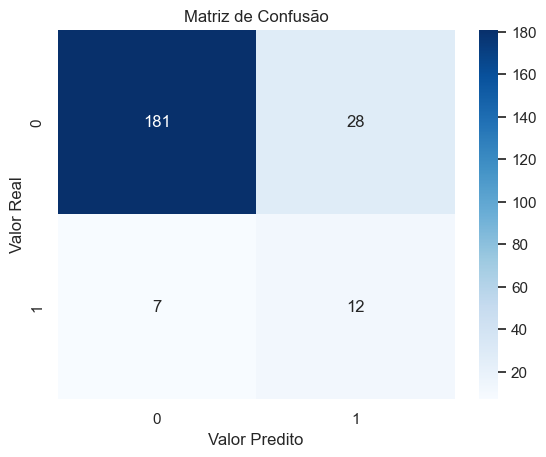

In [535]:
#Instanciando o modelo com kernel 'poly'
svm = SVC(kernel='poly', random_state = 42)

cv_scores = cross_val_score(svm, X_train_balanced, y_train_balanced, cv = 10, scoring='accuracy')
print(f"Acurácia média da validação cruzada: {cv_scores.mean() * 100:.2f}%")
print(f"Desvio padrão da acurácia: {cv_scores.std() * 100:.2f}%")

svm.fit(X_train_balanced, y_train_balanced)

y_pred = svm.predict(X_test)

matriz_conf = confusion_matrix(y_test, y_pred)

sns.heatmap(matriz_conf, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['0', '1'], 
            yticklabels=['0', '1'])

plt.title('Matriz de Confusão')
plt.xlabel('Valor Predito')
plt.ylabel('Valor Real');

print('Relatório do modelo\n\n', classification_report(y_test, y_pred))

# Cenário 2: Selected features

## Seleção de Características

In [538]:
selector = SelectKBest(score_func = f_classif, k=5)
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)

view_features = X.columns[selector.get_support()]

print("Características selecionadas:\n", view_features)

Características selecionadas:
 Index(['phq_score', 'depressiveness', 'depression_treatment',
       'anxiety_diagnosis', 'anxiety_treatment'],
      dtype='object')


## Balanceamento dos dados de treino selecionados

In [540]:
X_train_balanced_selected, y_train_balanced_selected = smote.fit_resample(X_train_selected, y_train)

print(f"Distribuição das classes após SMOTE: {Counter(y_train_balanced_selected)}")

Distribuição das classes após SMOTE: Counter({0: 484, 1: 484})


## Treinamento e avaliação do modelo com kernel 'rbf'

Acurácia média da validação cruzada: 90.39%
Desvio padrão da acurácia: 3.80%
Relatório do modelo

               precision    recall  f1-score   support

           0       0.98      0.97      0.97       209
           1       0.68      0.79      0.73        19

    accuracy                           0.95       228
   macro avg       0.83      0.88      0.85       228
weighted avg       0.96      0.95      0.95       228



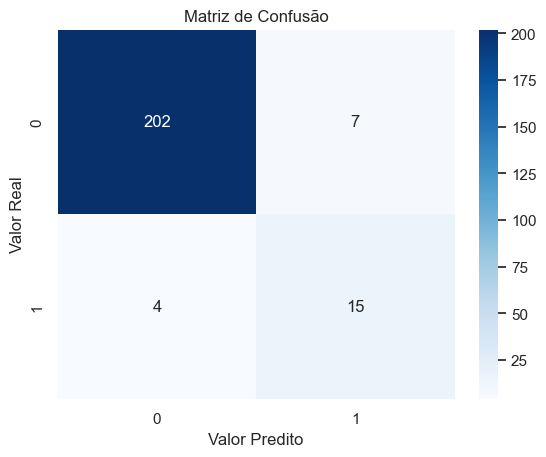

In [542]:
#Instanciando o modelo com kernel 'rbf' (default)
svm = SVC(kernel='rbf', random_state = 42)

cv_scores = cross_val_score(svm, X_train_balanced_selected, y_train_balanced_selected, cv = 10, scoring='accuracy')
print(f"Acurácia média da validação cruzada: {cv_scores.mean() * 100:.2f}%")
print(f"Desvio padrão da acurácia: {cv_scores.std() * 100:.2f}%")

svm.fit(X_train_balanced_selected, y_train_balanced_selected)

y_pred = svm.predict(X_test_selected)

matriz_conf = confusion_matrix(y_test, y_pred)

sns.heatmap(matriz_conf, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['0', '1'], 
            yticklabels=['0', '1'])

plt.title('Matriz de Confusão')
plt.xlabel('Valor Predito')
plt.ylabel('Valor Real');

print('Relatório do modelo\n\n', classification_report(y_test, y_pred))

## Treinamento e avaliação do modelo com kernel 'linear'

Acurácia média da validação cruzada: 88.94%
Desvio padrão da acurácia: 3.00%
Relatório do modelo

               precision    recall  f1-score   support

           0       0.98      0.96      0.97       209
           1       0.62      0.79      0.70        19

    accuracy                           0.94       228
   macro avg       0.80      0.87      0.83       228
weighted avg       0.95      0.94      0.95       228



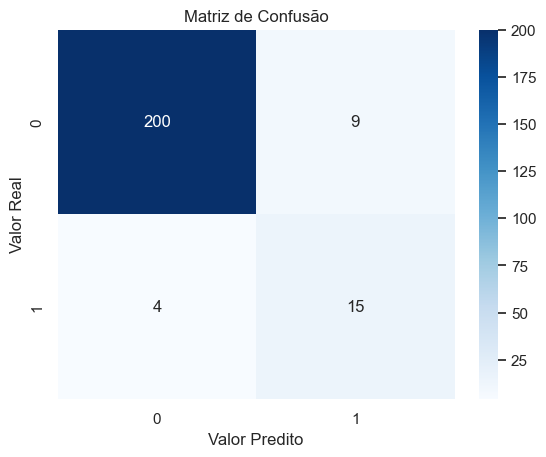

In [544]:
#Instanciando o modelo com kernel 'linear'
svm = SVC(kernel='linear', random_state = 42)

cv_scores = cross_val_score(svm,X_train_balanced_selected, y_train_balanced_selected, cv = 10, scoring='accuracy')
print(f"Acurácia média da validação cruzada: {cv_scores.mean() * 100:.2f}%")
print(f"Desvio padrão da acurácia: {cv_scores.std() * 100:.2f}%")

svm.fit(X_train_balanced_selected, y_train_balanced_selected)

y_pred = svm.predict(X_test_selected)

matriz_conf = confusion_matrix(y_test, y_pred)

sns.heatmap(matriz_conf, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['0', '1'], 
            yticklabels=['0', '1'])

plt.title('Matriz de Confusão')
plt.xlabel('Valor Predito')
plt.ylabel('Valor Real');

print('Relatório do modelo\n\n', classification_report(y_test, y_pred))

## Treinamento e avaliação do modelo com kernel 'poly'

Acurácia média da validação cruzada: 89.97%
Desvio padrão da acurácia: 3.55%
Relatório do modelo

               precision    recall  f1-score   support

           0       0.98      0.97      0.98       209
           1       0.71      0.79      0.75        19

    accuracy                           0.96       228
   macro avg       0.85      0.88      0.86       228
weighted avg       0.96      0.96      0.96       228



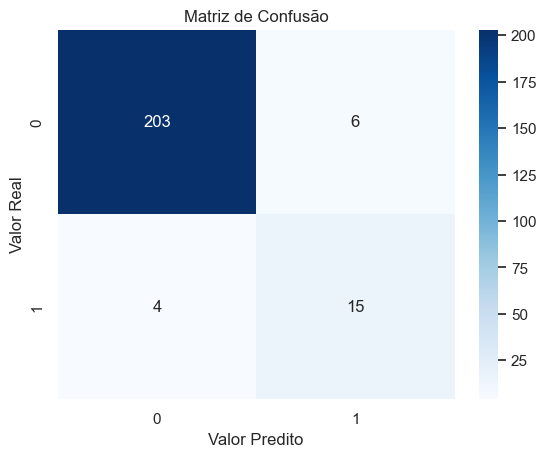

In [546]:
#Instanciando o modelo com kernel 'poly'
svm = SVC(kernel='poly', random_state = 42)

cv_scores = cross_val_score(svm, X_train_balanced_selected, y_train_balanced_selected, cv = 10, scoring='accuracy')
print(f"Acurácia média da validação cruzada: {cv_scores.mean() * 100:.2f}%")
print(f"Desvio padrão da acurácia: {cv_scores.std() * 100:.2f}%")

svm.fit(X_train_balanced_selected, y_train_balanced_selected)

y_pred = svm.predict(X_test_selected)

matriz_conf = confusion_matrix(y_test, y_pred)

sns.heatmap(matriz_conf, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['0', '1'], 
            yticklabels=['0', '1'])

plt.title('Matriz de Confusão')
plt.xlabel('Valor Predito')
plt.ylabel('Valor Real');

print('Relatório do modelo\n\n', classification_report(y_test, y_pred))